# Section 6

In [1]:
import cvxpy as cp
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler


class color:
    PURPLE = '\033[95m'
    CYAN = '\033[96m'
    DARKCYAN = '\033[36m'
    BLUE = '\033[94m'
    GREEN = '\033[92m'
    YELLOW = '\033[93m'
    RED = '\033[91m'
    BOLD = '\033[1m'
    UNDERLINE = '\033[4m'
    END = '\033[0m'

Implement the mean absolute error:
$$
MAE = \frac{1}{N}\sum_{i=1}^N |y_i-x_i^\top\theta|
$$

In [2]:
def get_MAE(theta, X, y):
    # --------------
    # Your Code Here
    # --------------
    mae = np.mean(np.abs(y - X @ theta))
    return mae

## Preprocessing

In [3]:
# load the dataset
df_mat_alcohol = pd.read_csv('../student-mat.csv')

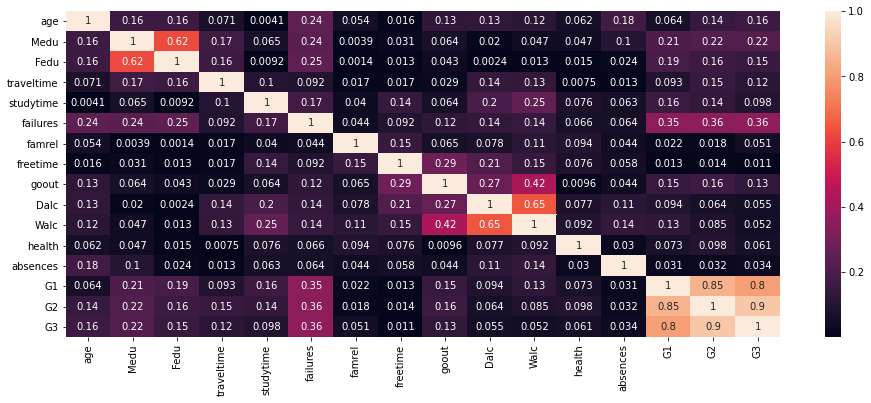

In [4]:
# plot correlation matrix
plt.figure(figsize=(16, 6))
sns.heatmap(df_mat_alcohol.corr().abs(),annot=True);

In [5]:
# print all columns
df_mat_alcohol.columns

Index(['school', 'sex', 'age', 'address', 'famsize', 'Pstatus', 'Medu', 'Fedu',
       'Mjob', 'Fjob', 'reason', 'guardian', 'traveltime', 'studytime',
       'failures', 'schoolsup', 'famsup', 'paid', 'activities', 'nursery',
       'higher', 'internet', 'romantic', 'famrel', 'freetime', 'goout', 'Dalc',
       'Walc', 'health', 'absences', 'G1', 'G2', 'G3'],
      dtype='object')

In [6]:
# convert labels to numerical values

df_mat_alcohol.schoolsup = df_mat_alcohol.schoolsup.eq('yes').mul(1)
df_mat_alcohol.famsup = df_mat_alcohol.famsup.eq('yes').mul(1)
df_mat_alcohol.paid = df_mat_alcohol.paid.eq('yes').mul(1)
df_mat_alcohol.activities = df_mat_alcohol.activities.eq('yes').mul(1)
df_mat_alcohol.nursery = df_mat_alcohol.nursery.eq('yes').mul(1)
df_mat_alcohol.higher = df_mat_alcohol.higher.eq('yes').mul(1)
df_mat_alcohol.internet = df_mat_alcohol.internet.eq('yes').mul(1)
df_mat_alcohol.romantic = df_mat_alcohol.romantic.eq('yes').mul(1)

In [7]:
# one hot encoding for the columns

one_hot = pd.get_dummies(df_mat_alcohol['school'])
df_mat_alcohol = df_mat_alcohol.drop('school',axis = 1)
df_mat_alcohol = df_mat_alcohol.join(one_hot)


one_hot = pd.get_dummies(df_mat_alcohol['sex'])
df_mat_alcohol = df_mat_alcohol.drop('sex',axis = 1)
df_mat_alcohol = df_mat_alcohol.join(one_hot)

one_hot = pd.get_dummies(df_mat_alcohol['address'])
df_mat_alcohol = df_mat_alcohol.drop('address',axis = 1)
df_mat_alcohol = df_mat_alcohol.join(one_hot)

one_hot = pd.get_dummies(df_mat_alcohol['famsize'])
df_mat_alcohol = df_mat_alcohol.drop('famsize',axis = 1)
df_mat_alcohol = df_mat_alcohol.join(one_hot)


one_hot = pd.get_dummies(df_mat_alcohol['Pstatus'])
df_mat_alcohol = df_mat_alcohol.drop('Pstatus',axis = 1)
df_mat_alcohol = df_mat_alcohol.join(one_hot)

one_hot = pd.get_dummies(df_mat_alcohol['guardian'])
df_mat_alcohol = df_mat_alcohol.drop('guardian',axis = 1)
df_mat_alcohol = df_mat_alcohol.join(one_hot)


In [8]:
# drop the columns that will not be used
df_mat_alcohol = df_mat_alcohol.drop(columns=['Mjob', 'Fjob', 'G1', 'G2', 'reason'])

In [9]:
df_mat_alcohol.head()

,age,Medu,Fedu,traveltime,studytime,failures,schoolsup,famsup,paid,activities,...,M,R,U,GT3,LE3,A,T,father,mother,other
0,18,4,4,2,2,0,1,0,0,0,...,0,0,1,1,0,1,0,0,1,0
1,17,1,1,1,2,0,0,1,0,0,...,0,0,1,1,0,0,1,1,0,0
2,15,1,1,1,2,3,1,0,1,0,...,0,0,1,0,1,0,1,0,1,0
3,15,4,2,1,3,0,0,1,1,1,...,0,0,1,1,0,0,1,0,1,0
4,16,3,3,1,2,0,0,1,1,0,...,0,0,1,1,0,0,1,1,0,0


In [11]:
# Standarization

cols = df_mat_alcohol.columns
x = df_mat_alcohol.values #returns a numpy array
min_max_scaler = MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
df_mat_alcohol = pd.DataFrame(x_scaled, columns =cols )

Implement the problem from Question 7.1 (Use the `GLPK` solver)

In [12]:
df_train = df_mat_alcohol.loc[:, df_mat_alcohol.columns != 'G3']
X, X_test, Y, Y_test = train_test_split(df_train, 
                                        np.expand_dims(df_mat_alcohol['G3'], 1), 
                                        test_size=0.5, random_state=0)

# add the bias term
X = np.hstack([np.ones([X.shape[0],1]), X])
X_test = np.hstack([np.ones([X_test.shape[0],1]), X_test])

print(X.shape)
print(Y.shape)

(197, 35)
(197, 1)


### Robust Cross Validation

In [13]:
# get dimensions
N = X.shape[0]
k = np.floor(0.75*N).astype('int')
D = X.shape[1]

print('N shape: \t{}'.format(N))
print('k shape: \t{}'.format(k))
print('D shape: \t{}'.format(D))

N shape: 	197
k shape: 	147
D shape: 	35


In [14]:
# define coefficients 
b = np.vstack((np.ones((N,1)), k))
A = np.vstack((np.identity(N), np.ones((1,N))))

# define the decision variables
theta = cp.Variable((D,1))
p = cp.Variable((N+1,1)) # beta = p[:-1], alpha = p[-1]
v = cp.Variable((D,1))

# define contraints
constraints =   [   A.T @ p >= 1/k * (Y - X @ theta),
                    A.T @ p >= -1/k * (Y - X @ theta),
                    theta <= v,
                    -theta <= v,
                    p[:-1] >= 0
                ]

In [15]:
# lambdas
lambdas = np.logspace(-5.0, -1.0, num=50)
best_mae = np.inf # initial value for best_mae

for lam in lambdas:
    ###
    objective = cp.Minimize( b.T @ p + lam * np.ones((D,1)).T @ v )
    prob = cp.Problem(objective, constraints)
    cost = prob.solve(solver=cp.GLPK)
    ###

    # get z by sorting the absolute error of each sample
    ind = np.argsort( np.abs(Y - X @ theta.value), axis=0)[::-1]
    z = np.zeros(N)
    z[ind[:k]] = 1
    z = z.astype(bool)

    X_train = X[z]
    X_val = X[~z]
    Y_train = Y[z]
    Y_val = Y[~z]

    # Check if the sorted training indices get the same cost as the solver
    # print(get_MAE(theta.value, X_train, Y_train) + lam * np.linalg.norm(theta.value, 1))
    # print(cost)

    mae = get_MAE(theta.value, X_val, Y_val)
    if mae < best_mae:
        best_z = z
        best_mae = mae
        best_theta = theta.value
        best_lambda = lam

    # print("Lambda: {:.12f}".format(lam))
    # print(color.BOLD + 'Validation Results' + color.END)
    # print('MAE: {:.12f}'.format(get_MAE(theta.value, X_val, Y_val)))
    # print(color.BOLD + 'Training Results' + color.END)
    # print('MAE: {:.12f}'.format(get_MAE(theta.value, X_train, Y_train)))
    # print(color.BOLD + 'Test Results' + color.END)
    # print('MAE: {:.12f}'.format(get_MAE(theta.value, X_test, Y_test)))
    # print(50*'-')

print("Best lambda: {:.12f}".format(best_lambda))
print(color.BOLD + 'Validation Results' + color.END)
print('MAE: {:.12f}'.format(get_MAE(best_theta, X[~best_z], Y[~best_z])))
print(color.BOLD + 'Training Results' + color.END)
print('MAE: {:.12f}'.format(get_MAE(best_theta, X[best_z], Y[best_z])))
print(color.BOLD + 'Test Results' + color.END)
print('MAE: {:.12f}'.format(get_MAE(best_theta, X_test, Y_test)))
print(50*'-')

Best lambda: 0.100000000000
Validation Results
MAE: 0.019000000000
Training Results
MAE: 0.201700680272
Test Results
MAE: 0.177020202020
--------------------------------------------------


In [16]:
# print best values
print('Best indices for training set: \n{}'.format(best_z.astype(int).T))
print('Cardinality of best training set: \n{}'.format(best_z.sum()))
print('Best theta: \n{}'.format(best_theta))
print('Best lambda: \t{:.12f}'.format(best_lambda))
print('Best MAE val:\t{:.12f}'.format(best_mae))

Best indices for training set: 
[1 1 1 1 1 1 1 1 0 0 1 0 1 1 0 1 1 1 1 1 0 0 1 1 1 1 1 1 1 1 0 1 1 1 1 0 1
 1 0 0 0 1 1 0 1 1 1 1 1 1 1 0 1 1 0 1 1 1 1 1 0 1 1 1 0 1 0 1 1 1 1 1 1 1
 1 1 1 1 0 1 0 1 1 1 1 1 0 0 1 1 1 1 1 1 1 1 0 1 0 1 1 0 0 1 1 1 0 1 1 1 1
 1 1 0 1 1 1 1 1 0 0 1 1 0 1 0 1 1 1 1 1 1 1 1 0 1 1 0 1 1 1 1 0 1 1 0 0 1
 0 1 1 0 1 1 0 0 1 1 0 0 0 0 1 1 1 1 0 1 1 1 1 1 1 1 1 0 1 1 1 0 1 0 1 1 1
 1 1 1 1 1 1 0 1 1 1 1 0]
Cardinality of best training set: 
147
Best theta: 
[[ 4.00000000e-01]
 [ 0.00000000e+00]
 [-4.78133158e-17]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [ 1.00000000e-01]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [

### Standard Cross Validation

In [17]:
# split the X, Y into  X_train, Y_train and X_val, Y_val
X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.25, random_state=42)

print(X_train.shape)
print(Y_train.shape)

(147, 35)
(147, 1)


In [18]:
# get dimensions for training
N = X_train.shape[0]
D = X_train.shape[1]

In [19]:
# define the decision variables
u = cp.Variable((N,1))
v = cp.Variable((D,1))
theta = cp.Variable((D,1))

# lambdas
lambdas = np.logspace(-5.0, -1.0, num=50)
best_mae = np.inf # initial value for best_mae

for lam in lambdas:
    ###
    objective = cp.Minimize(1/N * np.ones((N,1)).T @ u + lam * np.ones((D,1)).T @ v)
    constraints = [ Y_train - X_train @ theta <= u,
                -Y_train + X_train @ theta <= u,
                theta <= v,
                -theta <= v,
    ]

    prob = cp.Problem(objective, constraints)
    cost = prob.solve(solver=cp.GLPK)

    ####   
    mae = get_MAE(theta.value, X_val, Y_val)
    if mae < best_mae:
        best_mae = mae
        best_theta = theta.value
        best_lambda = lam

    # print("Lambda: {:.12f}".format(lam))
    # print(color.BOLD + 'Validation Results' + color.END)
    # print('MAE: {:.12f}'.format(get_MAE(theta.value, X_val, Y_val)))
    # print(color.BOLD + 'Training Results' + color.END)
    # print('MAE: {:.12f}'.format(get_MAE(theta.value, X_train, Y_train)))
    # print(color.BOLD + 'Test Results' + color.END)
    # print('MAE: {:.12f}'.format(get_MAE(theta.value, X_test, Y_test)))
    # print(50*'-')

print("Best lambda: {:.12f}".format(best_lambda))
print(color.BOLD + 'Validation Results' + color.END)
print('MAE: {:.12f}'.format(get_MAE(best_theta, X_val, Y_val)))
print(color.BOLD + 'Training Results' + color.END)
print('MAE: {:.12f}'.format(get_MAE(best_theta, X_train, Y_train)))
print(color.BOLD + 'Test Results' + color.END)
print('MAE: {:.12f}'.format(get_MAE(best_theta, X_test, Y_test)))
print(50*'-')

Best lambda: 0.001599858720
Validation Results
MAE: 0.157411091336
Training Results
MAE: 0.130972677878
Test Results
MAE: 0.178483135763
--------------------------------------------------


In [20]:
# print best values
print('Best theta: \n{}'.format(best_theta))
print('Best lambda: \t{:.12f}'.format(best_lambda))
print('Best MAE val:\t{:.12f}'.format(best_mae))

Best theta: 
[[ 2.65347612e-01]
 [-1.94956544e-01]
 [ 1.33464775e-01]
 [ 1.25051567e-01]
 [ 6.32334883e-02]
 [ 1.72262948e-01]
 [-1.18557231e-01]
 [-6.80994568e-02]
 [-6.83409818e-02]
 [-1.81920811e-02]
 [-9.10200491e-03]
 [-1.50599540e-02]
 [ 5.39298773e-02]
 [-1.95041714e-02]
 [-7.60147682e-03]
 [-1.45916633e-02]
 [ 1.07823806e-01]
 [-4.63743658e-02]
 [ 5.00215494e-02]
 [-2.66012759e-02]
 [-2.52830061e-02]
 [ 6.41045022e-02]
 [ 3.95944878e-02]
 [ 0.00000000e+00]
 [ 1.66533454e-16]
 [ 2.74760762e-02]
 [ 0.00000000e+00]
 [ 9.44177378e-02]
 [ 6.26683276e-03]
 [-7.42836190e-17]
 [ 0.00000000e+00]
 [ 3.53667152e-02]
 [ 3.07086252e-03]
 [ 0.00000000e+00]
 [ 6.82096403e-02]]
Best lambda: 	0.001599858720
Best MAE val:	0.157411091336
